
# Tweet Sentiment Extraction

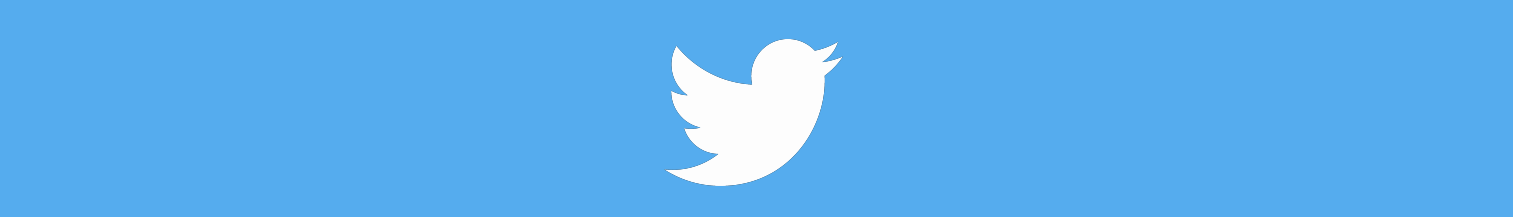


## Overview

This Notebook will be completed in two main ways.<br/>
First, find and visualize useful data or meaningful relationships within the data.<br/>
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.<br/><br/>

This competition does not categorize the positive or negative of a sentence, unlike a general emotional analysis competition.<br/>
In the sentence, it was interesting in that it was a contest to extract the sentence that influenced the emotion of the sentence the most. 
##### "We should keep in mind that we should extract sentences, not categorize sentiment."<br/>


#### My opinion :
Let me explain how to use the data when modelig :)


***

## My workflow
#### 1. Import & Install libray
* Import basic libray
* Import Enginnering libray
* Install stopwords list

#### 2. Check out my data
* Check Shape / Info

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the "sentiment" columns count
* Number of alphabets by sentence / Number of words by sentence
* Bi-gram by sentiment per texts in Tweets

#### 4. Prepocessing Data
* Drop null rows & useless columns
* Cleansing "text" / "selected_text" data

#### 5. Visualization [After Preprocessing]
* Wordcloude by sentiment per selected text in Tweets

#### 5. Modeling
* Not yet

# 1. Import & Install libray
* Import basic libray
* Import Enginnering libray
* Install stopwords list

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [8]:
import re
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

import tokenizers

import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# 2. Check out my data
* Check Shape / Info
* Set color palette

In [11]:
print("Train data size : {}".format(train_df.shape))
print("Test data size : {}".format(test_df.shape))

Train data size : (27481, 4)
Test data size : (3534, 3)


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


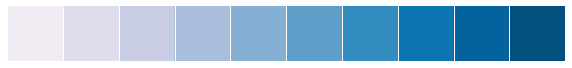

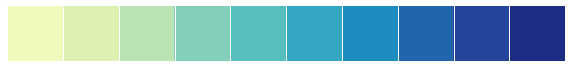

In [13]:
PuBu_palette = sns.color_palette("PuBu", 10)
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(PuBu_palette)
sns.palplot(YlGnBu_palette)

#### ✔️ This notebook will use this palettes.

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the null values
* Plot the "sentiment" columns count
* Number of alphabets by sentence / Number of words by sentence
* Bi-gram by sentiment per texts in Tweets

### 3-1)  Plot the Null Values

In [14]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
textID,0
text,1
selected_text,1
sentiment,0


In [15]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
textID,0
text,0
sentiment,0


<AxesSubplot:>

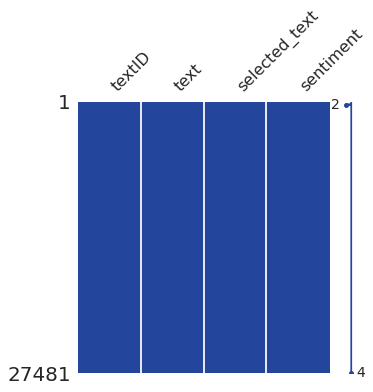

In [16]:
msno.matrix(df=train_df.iloc[:,:],figsize=(5,5),color=YlGnBu_palette[8])

### 3-2)  Plot the "sentiment" columns count

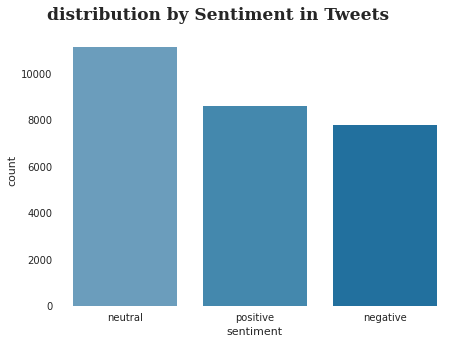

In [17]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax = sns.countplot(train_df["sentiment"].sort_values(ascending=False),
              order = train_df['sentiment'].value_counts().index,
              palette=PuBu_palette[-5:])
ax.patch.set_alpha(0)
fig.text(0.1,0.92,"distribution by Sentiment in Tweets", fontweight="bold", fontfamily='serif', fontsize=17)
plt.show()

### 3-3) Number of alphabets by sentence / Number of words by sentence

In [18]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [19]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [20]:
train_df['length_alphabets'] = train_df['text'].apply(lambda x: get_length_alphabets(x))
train_df['length_words'] = train_df['text'].apply(lambda x: get_length_words(x))
train_df.head()

,textID,text,selected_text,sentiment,length_alphabets,length_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,8
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,11
2,088c60f138,my boss is bullying me...,bullying me,negative,25,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,6
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,15


#### 💡 We can check dataframes describe ([length_alphabets] / [length_words] )

In [21]:
train_df.describe()

,length_alphabets,length_words
count,27481.000000,27481.000000
mean,68.327645,13.779448
std,35.605403,7.169974
min,3.000000,1.000000
25%,39.000000,8.000000
50%,64.000000,13.000000
75%,97.000000,19.000000
max,141.000000,101.000000


In [22]:
PuBu_palette

[(0.946236063052672, 0.9233525567089581, 0.9588465974625143),
 (0.8768319876970396, 0.8676509034986544, 0.928166089965398),
 (0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.6645444059976933, 0.7476355247981545, 0.8623760092272202),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407),
 (0.36718185313341023, 0.6273740868896578, 0.7905420991926182),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.05125720876585929, 0.4598846597462514, 0.7005305651672433),
 (0.017424067666282197, 0.39117262591311036, 0.613763936947328),
 (0.013502499038831219, 0.3158169934640523, 0.4950711264898116)]

In [23]:
three_PuBu_palette = list()
three_PuBu_palette.append(PuBu_palette[2])
three_PuBu_palette.append(PuBu_palette[6])
three_PuBu_palette.append(PuBu_palette[4])
three_PuBu_palette

[(0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407)]

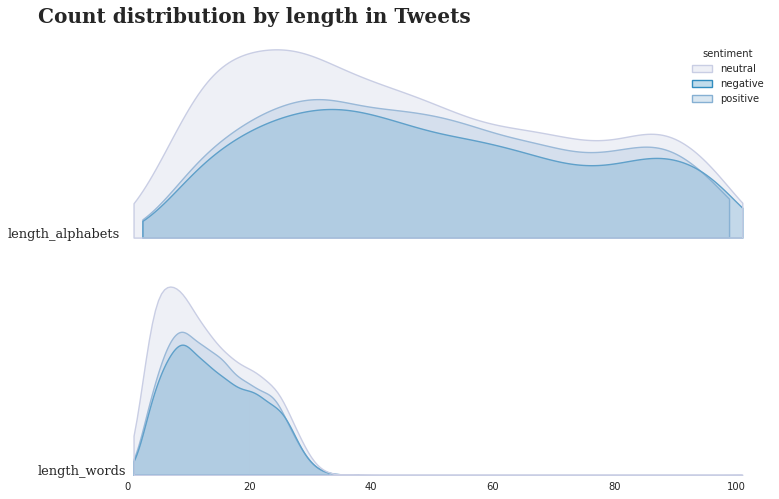

In [24]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2,1)

axes = list()

for index, data in zip(range(2), train_df):
    axes.append(fig.add_subplot(gs[index, 0]))
    
    
    if index==0:
        sns.kdeplot(x='length_alphabets', data=train_df, 
                        fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                        lw=1.4 , hue='sentiment', palette=three_PuBu_palette,
                         alpha=0.3)
    else:
        sns.kdeplot(x='length_words', data=train_df, 
                    fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                    lw=1.4 , hue='sentiment',palette=three_PuBu_palette,
                     alpha=0.3) 

    axes[index].set_yticks([])
    if index != 1 : axes[index].set_xticks([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('')
    axes[index].spines[["top","right","left","bottom"]].set_visible(False)
    
    
    if index == 0:
        axes[index].text(-0.2,0,"length_alphabets",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
    else:
        axes[index].text(-0.2,0,"length_words",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
        
        
    axes[index].patch.set_alpha(0)
    if index != 0 : axes[index].get_legend().remove()
        
fig.text(0.05,0.91,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

### 3-4) Bi-gram by sentiment per texts in Tweets

In [25]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

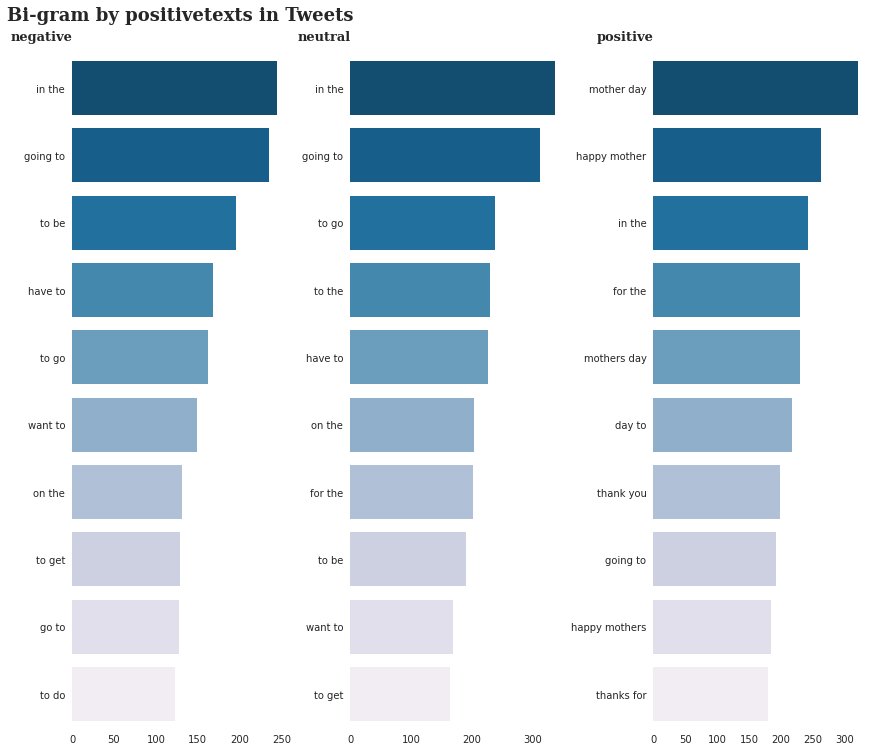

In [26]:
fig, axes = plt.subplots(1,3, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(train_df['sentiment']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = get_top_tweet_bigrams(train_df[train_df['sentiment']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i], palette=PuBu_palette[::-1])
    axes[i].text(0,-0.7, sentiment, fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Bi-gram by {}texts in Tweets".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

# 4. Prepocessing Data
* Drop null rows & useless columns
* Cleansing "text" / "selected_text" data

### 4-1) Drop null rows & useless columns

In [27]:
train_df_before_drop_shape = train_df.shape
test_df_before_drop_shape = test_df.shape

In [28]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [29]:
train_df.drop(['length_alphabets','length_words'], axis=1, inplace=True)

In [30]:
train_df_drop_shape = train_df.shape
test_df_drop_shape = test_df.shape

print("Train dataset Shape : {} => {}".format(train_df_before_drop_shape, train_df_drop_shape))
print("Test dataset Shape : {} => {}".format(test_df_before_drop_shape, test_df_drop_shape))

Train dataset Shape : (27481, 6) => (27480, 4)
Test dataset Shape : (3534, 3) => (3534, 3)


### 4-2) Cleansing "text" / "selected_text" data

In [31]:
def preprocess_fn(text):
    text = str(text)
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    # remove some puncts (except . ! # ? *)
    text = re.sub(r'[:"$%&\+,-/:;<=>@\\^_{|}~`]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    return text

In [32]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_fn(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x: preprocess_fn(x))

test_df['text'] = test_df['text'].apply(lambda x: preprocess_fn(x))

In [33]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego!,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,sons of **** why couldnt they put them on the ...,sons of ****,negative


# 5. Visualization [After Preprocessing]
* Wordcloude by sentiment per selected text in Tweets

### 5-1) Wordcloud by sentiment per selected text in Tweets

In [34]:
mask_dir = np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))

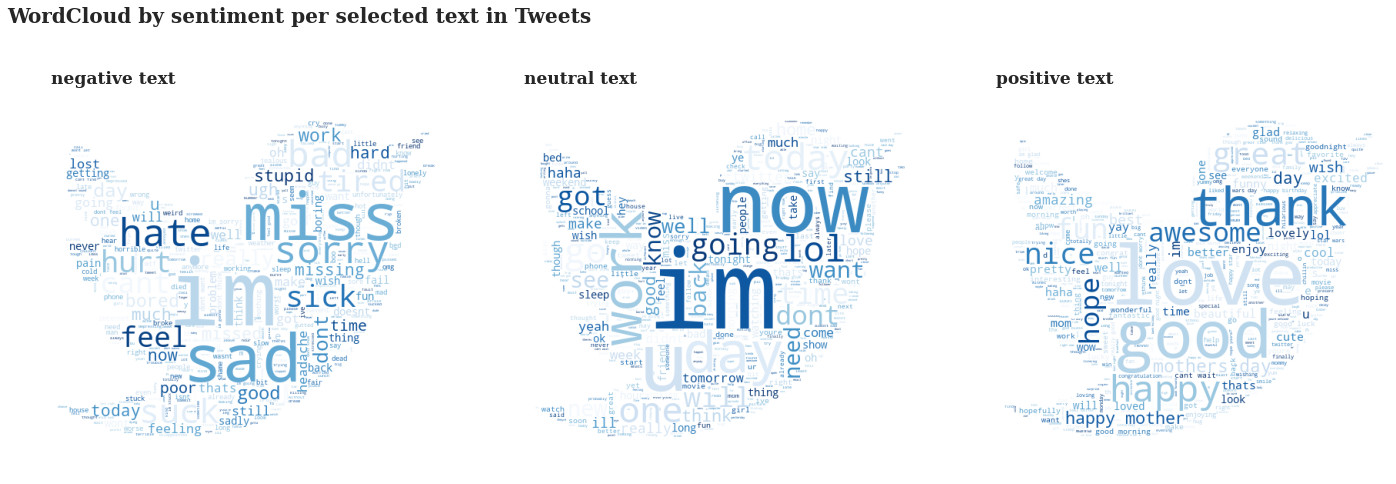

In [35]:
fig, axes = plt.subplots(1,3, figsize=(24,12))
sentiment_list = np.unique(train_df['sentiment'])

for i, sentiment in zip(range(3), sentiment_list):
    wc = WordCloud(background_color="white", max_words = 2000, width = 1600, height = 800, mask=mask_dir, colormap="Blues").generate(" ".join(train_df[train_df['sentiment']==sentiment]['selected_text']))
    
    axes[i].text(0.5,1, "{} text".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=17)
    axes[i].patch.set_alpha(0)
    axes[i].axis('off')
    axes[i].imshow(wc)

fig.text(0.1,0.8,"WordCloud by sentiment per selected text in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

# 6. Feature Enginnering 
* How to use Bert tokenization
* Convert to data suitable for Bert model (Dataset / Dataloader)

In [119]:
import torch
import torchtext
import torch.nn as nn
import torch.utils.data
from transformers import BertTokenizer, BertModel

import re
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random

from sklearn.model_selection import train_test_split

import tokenizers

import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image


from torch.utils.data import TensorDataset, DataLoader


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 6-1) How to use Bert tokenization

In [38]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [47]:
encode = bert_tokenizer.encode("Hi nice meet you !")
decode = bert_tokenizer.decode(encode)

print("Encode:", encode)
print("Decode:", decode)
print(bert_tokenizer.cls_token+":", bert_tokenizer.cls_token_id)
print(bert_tokenizer.sep_token+":", bert_tokenizer.sep_token_id)

Encode: [101, 7632, 3835, 3113, 2017, 999, 102]
Decode: [CLS] hi nice meet you! [SEP]
[CLS]: 101
[SEP]: 102


In [156]:
print(train_df['text'][0]) # original sentence
print("\n")

print(bert_tokenizer.tokenize(train_df['text'][0]))
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['text'][0])))
print("\n")

print(bert_tokenizer.tokenize(train_df['selected_text'][0]))
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['selected_text'][0])))

id have responded if i were going


['id', 'have', 'responded', 'if', 'i', 'were', 'going']
[8909, 2031, 5838, 2065, 1045, 2020, 2183]


['id', 'have', 'responded', 'if', 'i', 'were', 'going']
[8909, 2031, 5838, 2065, 1045, 2020, 2183]


### 6-2) Convert to data suitable for Bert model (Dataset / Dataloader)

In [79]:
class BertDataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len=False, is_label=False):
        self.df = df
        
        if max_len:
            self.max_len = max_len
        else:
            self.max_len = self.get_max_len()
            
        if is_label:
            self.label = self.get_label_ids()
        else:
            self.label = None

        self.input_ids, self.attention_masks, self.token_type_ids = self.get_bert_tokenize()

    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, index):
        data = {}
        row = self.df.iloc[index]
        
        data['input_ids'] = self.input_ids
        data['attention_masks'] = self.attention_masks
        data['token_type_ids'] = self.token_type_ids
        
        if self.label != None:
            data['label'] = self.label
        
        return data
    
    
    def get_max_len(self):
        max_len = 0
        for text in self.df['text']:

            # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
            input_ids = bert_tokenizer.encode(text, add_special_tokens=True)
            # Update the maximum sentence length.
            max_len = max(max_len, len(input_ids))

        return max_len
    
    
    def get_label_ids(self):
        label_ids = []

        for text in self.df['selected_text'].values:
            text_id = bert_tokenizer.encode(
                text,
                max_length=self.max_len,
                pad_to_max_length=True,
                add_special_tokens=True
            )
            label_ids.append(text_id)

        label_ids = torch.tensor(label_ids)
        return label_ids
    
    
    def get_bert_tokenize(self):
        
        text = self.df['text'].values
        sentiment = self.df['sentiment'].values
        
        input_ids = []
        attention_masks = []
        token_type_ids = []

        for i in range(len(text)):
            encoded = bert_tokenizer.encode_plus(
              sentiment[i],
              text[i],
              add_special_tokens=True,
              max_length=self.max_len,
              pad_to_max_length=True,
              return_token_type_ids=True,
              return_attention_mask=True,
              return_tensors='pt'
            )

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
            token_type_ids.append(encoded['token_type_ids'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        token_type_ids = torch.cat(token_type_ids, dim=0)

        return input_ids, attention_masks, token_type_ids  

In [114]:
train_dataset = BertDataset(train_df, is_label=True)
test_dataset = BertDataset(test_df, is_label=False)

In [155]:
print('Original text: ',train_df['text'][0])
print('Original text length: ',len(train_dataset[0]['input_ids'][0]))
print(train_dataset[0]['input_ids'][0])
print(train_dataset[0]['attention_masks'][0])
print(train_dataset[0]['token_type_ids'][0])
print("\n\n")

print('Selected text: ',train_df['selected_text'][0])
print(train_dataset[0]['label'][0])

Original text:  id have responded if i were going
Original text length:  73
tensor([ 101, 8699,  102, 8909, 2031, 5838, 2065, 1045, 2020, 2183,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 

* 1) input_ids : list of token ids to be fed to a model. We can see that all token ids have been padded to a length of max_len.
* 2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.
* 3) token_type_ids : list of token type ids to be fed to a model. These are also in the form of 0s and 1s and help to differentiate between the two sequences. The first sequence is the sentiment and the second is the text. Remember we had concatanated them. But why we need it? This is because the model has to differentiate between the two sequences and it will use these IDs to place a SEP token between them.<br/><br/>
=> https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert 

In [127]:
def get_train_val_loaders(dataset, val_size=0.2, batch_size=8):
    
    train_split, val_split = train_test_split(dataset, test_size=val_size)
    
    train_loader = torch.utils.data.DataLoader(
        train_split,
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2,
        drop_last=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_split,
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)
    
    dataloaders_dict = {"train": train_loader, "val": val_loader}
    
    return dataloaders_dict


def get_test_loader(dataset, batch_size=32):
    
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)  
    
    return loader

In [128]:
dict_loader = get_train_val_loaders(train_dataset)
test_loader = get_test_loader(test_dataset)

In [157]:
dict_loader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb9dd022250>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fb9dd022610>}

# 7.Modeling
* Bert model (Not yet)

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
class BertModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.bert = model
        self.hidden_size = self.bert.config.hidden_size
        self.layer = nn.Sequential(
            nn.Linear(self.hidden_size, 32),
            nn.Dropout(0.2),
        )
        self.FC = nn.Linear(32,2)
        
    def forward(self,inputs):
        
        encoded_layers, pooled_output = self.bert(input_ids=inputs[0],attention_mask=inputs[1])
        encoded_layers = encoded_layers.permute(1, 0, 2)
        enc_hiddens, (last_hidden, last_cell) = self.LSTM(pack_padded_sequence(encoded_layers, inputs[2]))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        output_hidden = F.dropout(output_hidden,0.2)
        output = self.clf(output_hidden)
        
        return F.sigmoid(output)

In [ ]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

##### reference 
* https://www.kaggle.com/subinium/tps-apr-highlighting-the-data : EDA part (Visualiztion)
* https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch : Modeling(Bert)
* https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert : Modeling(Bert)
###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈